In [1]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import ticker

%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using Theano backend.


In [2]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [67]:
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

ROWS = 64
COLS = 64
CHANNELS = 3

np.random.seed(10); random.seed(10)

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i] # 12.5 K cats
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i] # 12.5 K dogs
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:2000] + train_cats[:2000]
random.shuffle(train_images)
test_images =  test_images[:50]

def read_image(file_path):
    img = io.imread(file_path)
    return resize(img, (ROWS, COLS))

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    def process(idx, im_name):
        if idx == count-1:
            print('Finished Processing {} of {}'.format(idx+1, count))
        elif idx %250 == 0: 
            print('Processed {} of {}'.format(idx, count))
        data[idx] = np.array(read_image(im_name).T * 256, dtype=np.uint8)
    for idx, im_name in enumerate(images):
        process(idx, im_name)
    return data

train = prep_data(train_images)
print("\nTrain shape: {}\n".format(train.shape))

test = prep_data(test_images)
print("\nTest shape: {}\n".format(test.shape))

Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
Finished Processing 4000 of 4000

Train shape: (4000, 3, 64, 64)

Processed 0 of 50
Finished Processing 50 of 50

Test shape: (50, 3, 64, 64)



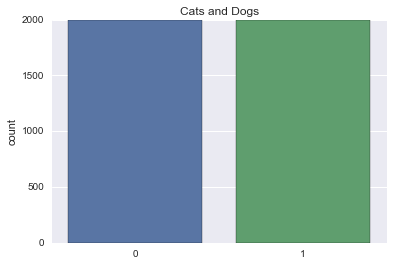

In [68]:
labels = [1 if 'dog' in f else 0 for f in train_images]
sns.countplot(labels)
sns.plt.title('Cats and Dogs')

In [8]:
# Compile
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'
%timeit -n 1 -r 1 loaded_model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

1 loop, best of 1: 17.1 ms per loop


In [69]:
otrain, train = train[:], train[2000:4000]
olabels, labels = labels[:], labels[2000:4000]

In [70]:
scores = loaded_model.evaluate(train, labels, verbose=0)

In [81]:
print("%s: %.2f" % (loaded_model.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

loss: 0.60
acc: 69.50%


In [72]:
fscores = loaded_model.evaluate(otrain, olabels, verbose=0)

In [80]:
print("%s: %.2f" % (loaded_model.metrics_names[0], fscores[0]))
print("%s: %.2f%%" % (loaded_model.metrics_names[1], fscores[1]*100))

loss: 0.60
acc: 69.73%


In [74]:
print(train.shape, otrain.shape)

(2000, 3, 64, 64) (4000, 3, 64, 64)


In [77]:
cscores = loaded_model.evaluate(otrain[:2000], olabels[:2000], verbose=0)

In [79]:
print("%s: %.2f" % (loaded_model.metrics_names[0], cscores[0]))
print("%s: %.2f%%" % (loaded_model.metrics_names[1], cscores[1]*100))

loss: 0.60
acc: 69.95%


In [65]:
predictions = loaded_model.predict(train, verbose=0)

Failed 537 of 2000
Showing 5 of wrongly classified
Wrong Prediction for 1640


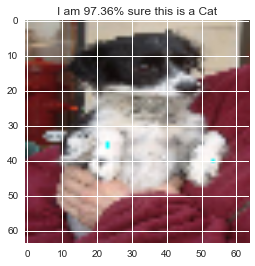

Wrong Prediction for 1928


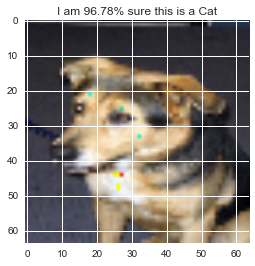

Wrong Prediction for 1902


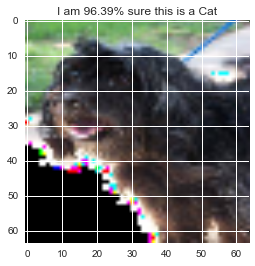

Wrong Prediction for 1904


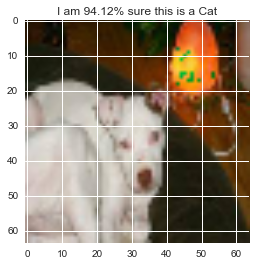

Wrong Prediction for 660


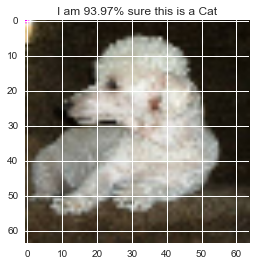

In [66]:
failed, values = [], []
for i,p in enumerate(predictions):
    if int(np.round(p)) != labels[i]:
        val = p if p > 0.5 else 1-p
        failed.append(i)
        values.append(float(val))

print('Failed %s of %s' %(len(failed), len(predictions)))
selected = [failed[i] for i in np.argsort(-np.asarray(values))]
limit = 5
print('Showing %s of wrongly classified' % limit)
for i in selected[:limit]:
    print('Wrong Prediction for %s' % i)
    plt.imshow(train[i].T)
    p = float(predictions[i])
    val = p if p > 0.5 else 1-p
    animal = 'Dog' if p > 0.5 else 'Cat'
    title = 'I am {:.2%} sure this is a {}'.format(val, animal)
    plt.title(title)
    plt.show()

In [53]:
labels[39], predictions[39]

(1, array([ 0.14600772], dtype=float32))

In [58]:
%prun [i for i in range(100)]

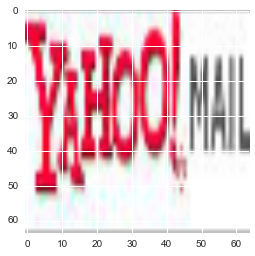

In [64]:
im = read_image('train/dog.4367.jpg')
plt.imshow(im)
plt.show()